# Parameter Calibration & Classify Using Hessian

This file provides example usage for calibrating some unknown parameters of a physics-based model. We use PyBaMM's SPMe model for this example. Further, the optimisation results are classified by analyzing the Hessian matrix eigenvectors of the cost function at the optimal point.

### Setting up the Environment

Before we begin, we need to ensure that we have all the necessary tools.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pybamm

import pybop
from pybop import classify_using_hessian


Create a reference dataset for the calibration process. We use higher order physics-based model (DFN) in this example. This can be replaced with actual experimental data.

In [2]:
model = pybamm.lithium_ion.DFN()
params = pybamm.ParameterValues("Chen2020")
pulse_time = 3500
initial_soc = 1.0
C_rate = 1  # 1C discharge rate
experiment = pybamm.Experiment(
    [
        f"Discharge at {C_rate}C for {pulse_time} seconds",
    ],
    period="1 seconds",
)
sim = pybamm.Simulation(model, parameter_values=params, experiment=experiment)
sim.solve(initial_soc=initial_soc)
solution = sim.solution
# Extract voltage, current, time from the solution
reference_voltage = solution["Terminal voltage [V]"].entries
reference_current = solution["Current [A]"].entries
reference_time = solution["Time [s]"].entries

Use Chen2020 dataset for the SPMe model. We tweak negative and positive particle diffusivity and assume these are unknown. We try to find them out using the optimization process.

In [3]:
parameter_set = pybamm.ParameterValues("Chen2020")

# Change the diffusivities to some random values
parameter_set["Negative particle diffusivity [m2.s-1]"] = (
    1.68e-12  # actual value - 3.3e-14
)
parameter_set["Positive particle diffusivity [m2.s-1]"] = (
    1.32e-16  # actual value - 4e-15
)

model = pybamm.lithium_ion.SPMe()

Next, we define the model parameters for optimisation.

In [4]:
parameter_set.update(
    {
        "Negative particle diffusivity [m2.s-1]": pybop.Parameter(
            bounds=[1e-16, 1e-12],
        ),
        "Positive particle diffusivity [m2.s-1]": pybop.Parameter(
            bounds=[1e-17, 1e-13],
        ),
    }
)
dataset = pybop.Dataset(
    {
        "Time [s]": reference_time,
        "Current function [A]": reference_current,
        "Voltage [V]": reference_voltage,
    }
)

Here, we set up the simulator, cost, and problem class.

In [5]:
parameter_set.set_initial_state(initial_soc)
simulator = pybop.pybamm.Simulator(
    model,
    parameter_values=parameter_set,
    protocol=dataset,
    # solver=pybamm.CasadiSolver(mode="safe", dt_max=10),
)
cost = pybop.SumSquaredError(dataset)
problem = pybop.Problem(simulator, cost)

Set up the optimiser and run it.

In [6]:
options = pybop.PintsOptions(
    max_unchanged_iterations=30,
    max_iterations=100,
)
optim = pybop.XNES(problem, options=options)
result = optim.run()

Compare ground truth vs optimised result.

In [7]:
pybop.plot.problem(problem, inputs=result.best_inputs, title="Optimised Comparison");

Visualize cost landscape.

In [8]:
pybop.plot.surface(result)

The Hessian matrix eigenvectors evaluated at the optimal point tell us about the so called "stiff" and "sloppy" directions. The Hessian matrix is evaluated numerically using finite difference approximations.

The optimiser has located a minimum.


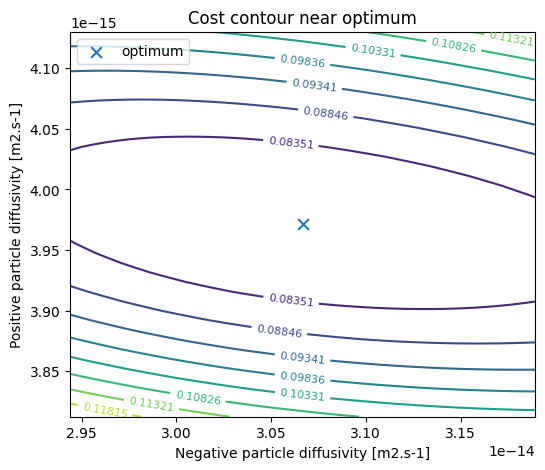

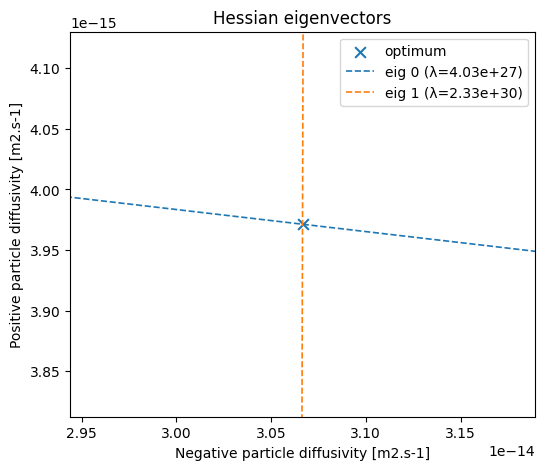

In [ ]:
msg,info = classify_using_hessian(result)
param0 = info["param0"]
param1 = info["param1"]
Z = info["Z"]
x = info["x"]
names = info["names"] or ("param0", "param1")
evecs = info["eigenvectors"]
evals = info["eigenvalues"]

# cost contour
fig, ax = plt.subplots(figsize=(6, 5))
finiteZ = Z[np.isfinite(Z)]
if finiteZ.size == 0:
    ax.text(0.5, 0.5, "No finite cost values on contour grid", ha="center", va="center")
else:
    vmin, vmax = np.nanmin(Z), np.nanmax(Z)
    levels = np.linspace(vmin, vmax, 10)
    cs = ax.contour(param0, param1, Z.T, levels=levels)
    ax.clabel(cs, inline=1, fontsize=8)

ax.scatter([x[0]], [x[1]], marker="x", s=60, label="optimum")
ax.set_xlabel(names[0] if names is not None else "param0")
ax.set_ylabel(names[1] if names is not None else "param1")
ax.set_title("Cost contour near optimum")
ax.legend(loc="best")

# eigenvector figure
fig_eig, ax_eig = plt.subplots(figsize=(6, 5))
ax_eig.scatter([x[0]], [x[1]], marker="x", s=60, label="optimum")

span_param0_len = info["span0"][1] - info["span0"][0]
span_param1_len = info["span1"][1] - info["span1"][0]
length = 0.5 * np.sqrt(span_param0_len**2 + span_param1_len**2)

# Plot eigenvectors
if evecs is not None and np.isfinite(evecs).all():
    for k in range(evecs.shape[1]):
        v = evecs[:, k].astype(float)
        nrm = np.linalg.norm(v)
        if nrm < 1e-20:
            continue
        vn = v / nrm
        p_minus = x - vn * length
        p_plus = x + vn * length
        ax_eig.plot(
            [p_minus[0], p_plus[0]],
            [p_minus[1], p_plus[1]],
            linestyle="--",
            linewidth=1.2,
            label=f"eig {k} (λ={evals[k]:.3g})",
        )

ax_eig.set_xlabel(names[0] if names is not None else "param0")
ax_eig.set_ylabel(names[1] if names is not None else "param1")
ax_eig.set_title("Hessian eigenvectors")
ax_eig.legend(loc="best")

# set the same axis limits as the contour plot for easy comparison
try:
    ax.set_xlim(info["span0"][0], info["span0"][1])
    ax.set_ylim(info["span1"][0], info["span1"][1])
    ax_eig.set_xlim(info["span0"][0], info["span0"][1])
    ax_eig.set_ylim(info["span1"][0], info["span1"][1])
except Exception:
    pass

plt.show()